In [5]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda


In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


## Parámetros

In [7]:
steps=20000
lr=1e-3

## Funciones

Definición de la función objetivo

In [8]:
def f(x):
    y=torch.sin(x)
    return y

Inicializar la red neuronal

In [9]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

    def lossNN(self,x,y):
      loss_val=self.loss_function(self.forward(x),y)
      return loss_val

    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.lossNN(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:
        
            print(loss)

        return loss

## Generación de datos

In [22]:
# get the analytical solution over the full domain
x = torch.linspace(0,2*np.pi,1000).view(-1,1) #prepare to NN
y = f(x)
print(x.shape, y.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])


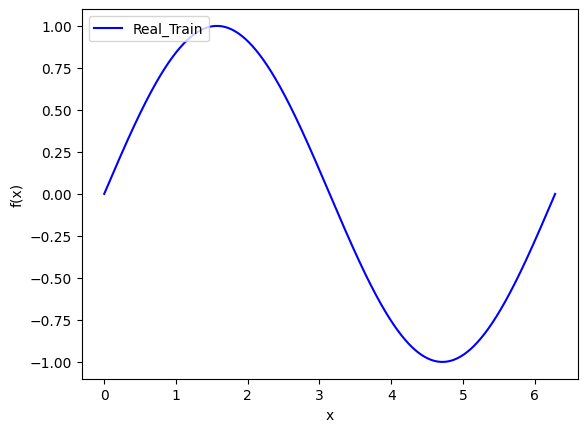

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [24]:
indices=np.arange(500)

train_idx,test_idx, _,_ = train_test_split(indices, indices, test_size=0.2, random_state=42)

x_train=x[train_idx]
y_train=y[train_idx]
x_test=x[test_idx]
y_test=y[test_idx]

## Entrenar la red neuronal

In [25]:
torch.manual_seed(123)
x_train=x_train.float().to(device)
y_train=y_train.float().to(device)
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [26]:
for i in range(steps):
    optimizer.zero_grad()
    yh = model(x_train)
    loss = model.lossNN(x_train,y_train)# use mean squared error
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(0.3309, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.1189e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.4109e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.6949e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.0653e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.1932e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5990e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(8.7179e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.4382e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.8186e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [27]:
print(model.lossNN(x_test.float().to(device),y_test.float().to(device)))

tensor(7.7217e-07, device='cuda:0', grad_fn=<MseLossBackward0>)


In [28]:
yh=model(x_train)
yh_test=model(x_test.float().to(device))

In [29]:
_,indices2=torch.sort(x_train.squeeze(1))
_,indices3=torch.sort(x_test.squeeze(1))

In [30]:
x_train_plot=x_train[indices2]
y_train_plot=y_train[indices2]
yh_plot=yh[indices2]
x_test_plot=x_test[indices3]
y_test_plot=y_test[indices3]
yh_test_plot=yh_test[indices3]

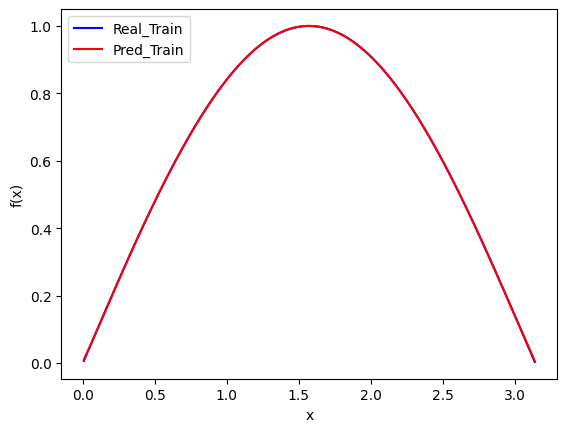

In [31]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot.detach().cpu().numpy(),y_train_plot.detach().cpu().numpy(),color='blue',label='Real_Train')
ax1.plot(x_train_plot.detach().cpu().numpy(),yh_plot.detach().cpu().numpy(),color='red',label='Pred_Train')
#ax1.plot(x_test_plot.detach().numpy(),y_test_plot.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_test_plot.detach().numpy(),yh_test_plot.detach().numpy(),color='orange',label='Pred_Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')